# Planar data classification with one hidden layer

We will build and implement a 2-class classification neural network with a single hidden layer.We can use a any 2-class dataset loaded from plot_function.py.We use noisy_moons data set in this notebook.You can further experiment with differnt data sets found in the notebook.The code for building data set is in the plot_function.py, which can be found in the custom_plotting_fns folder in the repository.


In [1]:
# import Packages
# plot_function provide various useful functions used in this project.You can find it in custom_plotting_fns in my repository
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from plot_function import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline
#Setting seed
np.random.seed(123) 

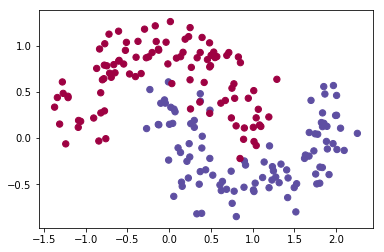

In [2]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# choose your dataset
dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualizing the data:
# numpy-array (matrix) X contains features (x1, x2)
#  numpy-array (vector) Y labels (red:0, blue:1).
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [3]:
#Checking the structure of data
shape_X =X.shape
shape_Y = Y.shape

 # training set size
m = X.shape[1] 

print ('shape of X is: ' + str(shape_X))
print ('shape of Y is: ' + str(shape_Y))
print ('Num of training examples= %d' % (m))

shape of X is: (2, 200)
shape of Y is: (1, 200)
Num of training examples= 200


## Logistic Regression

Before building a full neural network, we will first check how logistic regression performs on this problem.Though the dataset is not linearly separable and the logistic regression doesn't perform well we can just check how it performs initially.

In [4]:
# Training the logistic regression classifier
model_logistic = sklearn.linear_model.LogisticRegressionCV();
model_logistic.fit(X.T, Y.T);

C:\Users\sid\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression: 85 % (percentage of correctly labelled datapoints)


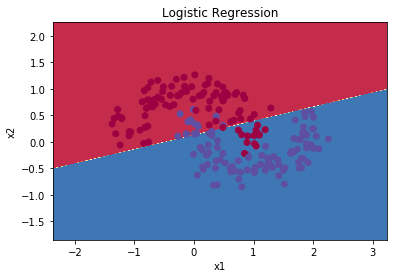

In [5]:
# We can plot and check the decision boundary for logistic regression
plot_decision_boundary(lambda x: model_logistic.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
predictions_logreg = model_logistic.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,predictions_logreg) + np.dot(1-Y,1-predictions_logreg))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

## Building Neural Net model

The general methodology to build a neural network is to 
   1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)
We build several functions to implement each of these and finally merge them to form a neural network model.The mathematical formulation can be seen below

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


### Defining the neural network structure ####
We first define the structure of neural network by providing 
 - n_x: the size of the input layer
 - n_h: the size of the hidden layer  and 
 - n_y: the size of the output layer

For our purpose we use 4 as the size of hidden layer .

In [6]:
def layer_sizes(X, Y):

    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

###  Initializing the model's parameters ####
- We will initialize the weights matrices with random values. 
- We will initialize the bias vectors as zeros. 

The function will return

 - params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)

In [7]:
def initialize_parameters(n_x, n_h, n_y):
 
    np.random.seed(123)     
   
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Implementing Forward Propogation ####

- We retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
- We compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.
- The function will return
    - A2 -- The sigmoid output of the second activation
    - cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"

In [8]:
def forward_propagation(X, parameters):

    # Retrieving each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implementing Forward Propagation to calculate A2 (probabilities)
  
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 =np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}    
    return A2, cache

### Compute cost###
We compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

The function will return
- cost -- cross-entropy cost

In [9]:
def compute_cost(A2, Y, parameters):

    m = Y.shape[1] 
    
    # Retrieving W1 and W2 from parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
   
    # Computing the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),1-Y)
    cost = - np.sum(logprobs)/Y.shape[1]

    cost = np.squeeze(cost)     
    assert(isinstance(cost, float))
    
    return cost

### Implementing Backward Propogation###
Using the cache computed during forward propagation, we now implement backward propagation.
- We use tanh as the activation function for hidden layers while sigmoid function is used for output layer
 - The function will return:
    grads: python dictionary containing gradients with respect to different parameters


In [10]:

def backward_propagation(parameters, cache, X, Y):
  
    m = X.shape[1]
    
    # retrieving W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieving A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 =  cache["A2"]
    
    # Backward propagation: calculating dW1, db1, dW2, db2. 
    dZ2= A2-Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = 1/m*np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = 1/m*(np.dot(dZ1,X.T))
    db1 = 1/m*np.sum(dZ1,axis=1,keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

### Gradient Descent ###
Using gradient descent rule below to  use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2). 

- $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.


In [11]:
def update_parameters(parameters, grads, learning_rate = 1.2):

    # Retrieving each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    
    # Retrieving each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Implementing Update rule for each parameter
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Building Neural Net model ####

We now combine all the functions to build a 2 layer Neural net model and predict the class label.
The function will return the parameters learned by the model ,which can be used to predict.

In [12]:

def model_nnet(X, Y, n_h, num_iterations = 10000, print_cost=False):

    np.random.seed(123)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initializing parameters and retrieving
    #W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
   
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
   
    
    # Implementing gradient descent

    for i in range(0, num_iterations):
         
       
        # Forward propagation. 
        #Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. 
        #Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. 
        #Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. 
        #Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
            
        # Printing the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### Predict

We use your model and parameter learned to predict by building predict() function.The function will return vector of predictions of the model (red: 0 / blue: 1)

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  `

In [13]:
def predict(parameters, X):

    # Computing probabilities using forward propagation, and classifying to 0/1 using 0.5 as the threshold.
   
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
   
    
    return predictions

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693202
Cost after iteration 1000: 0.071131
Cost after iteration 2000: 0.058246
Cost after iteration 3000: 0.052542
Cost after iteration 4000: 0.049059
Cost after iteration 5000: 0.046250
Cost after iteration 6000: 0.043451
Cost after iteration 7000: 0.041015
Cost after iteration 8000: 0.039018
Cost after iteration 9000: 0.037361


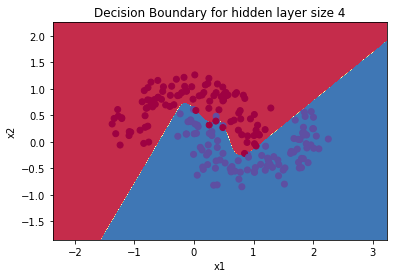

In [15]:
# Build a model with a n_h-dimensional hidden layer and 10000 iterations
parameters = model_nnet(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Ploting the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [16]:
# accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 97%


As Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression,the accuracy is really high compared to Logistic Regression.

## Hyper parameter tuning

### Learning rate 

We used 1.2 as learning rate.We can further check the accuracy for various learning rates.

### Hidden Layers
We can try out several hidden layer sizes to check for improvement in accuracy.We check for sizes [1, 2, 3, 4, 5, 20, 50]

Accuracy for 1 hidden units: 84.0 %
Accuracy for 2 hidden units: 83.5 %
Accuracy for 3 hidden units: 97.0 %
Accuracy for 4 hidden units: 97.5 %
Accuracy for 5 hidden units: 97.5 %
Accuracy for 20 hidden units: 97.5 %
Accuracy for 50 hidden units: 87.0 %


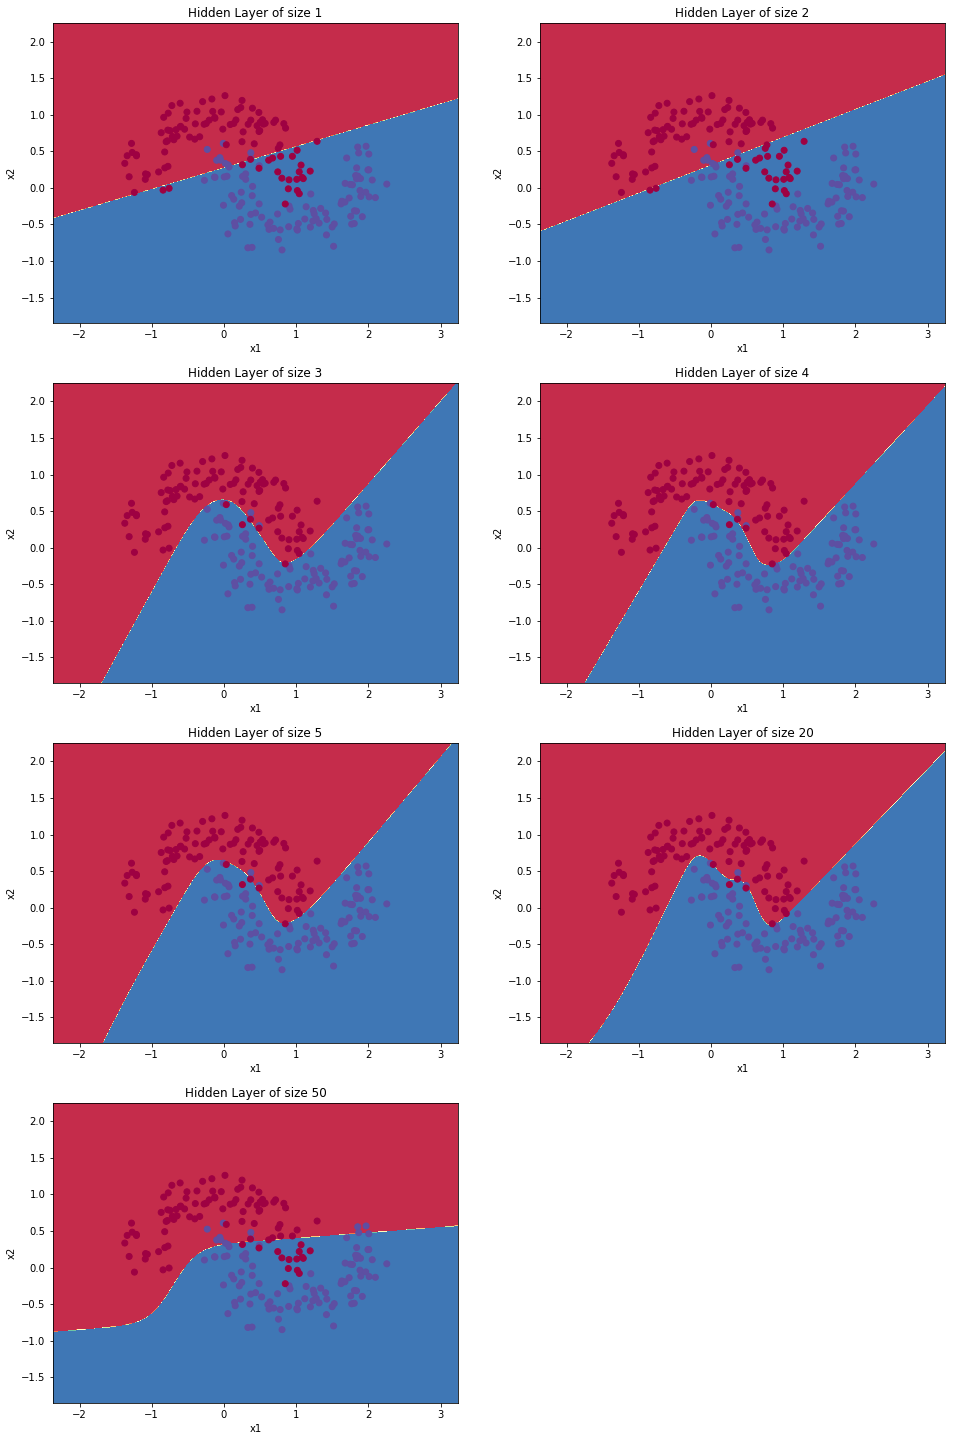

In [17]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = model_nnet(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

- We can observe that the models with more hidden units are able to fit the training set better, but will eventually  overfit the data. 
- The best hidden layer size seems to be around n_h = 5. 
- We can apply regularization techniques to use more number of hidden nodes without much overfitting. 

Reference:
 
- This project is based upon the assignments in Neural Networks and Deep Learning course by Andrew Ng in Coursera
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/